In [1]:
from mt.laser import get_func_gen_settings
%load_ext autoreload
%autoreload 2

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from mt.scan import Scan
from mt.constants import ANALYSIS_SPECIMEN, SCALE_FACTOR_2D, SCALE_FACTOR_3D
from mt.ct_utils import reslice
from mt.visualization import visualize_region_properties, visualize_region_correlation
import matplotlib.pyplot as plt

with open("analytics.pkl", "rb") as file:
    analytics = pickle.load(file)
specimen_overview = pd.read_csv("specimen.csv", header=0, delimiter=";")

In [2]:
# analytics = {}
# for ii, specimen in enumerate(ANALYSIS_SPECIMEN):
#     print(f"Processing specimen {specimen} ({ii+1}/{len(ANALYSIS_SPECIMEN)})")
#     path = "../../04_uCT/" + specimen + "/"
#     scan = Scan(path,
#                 downscale=True)
#     scan.load(logging=True)
#     scan.calculate_properties()
#     scan.save(logging=True)
#     analytics[specimen] = scan.analytics
# with open("analytics.pkl", "wb") as file:
#     pickle.dump(analytics, file)

# Load data

In [2]:
with open("analytics.pkl", "rb") as file:
    analytics = pickle.load(file)

In [3]:
specimen_overview = pd.read_csv("specimen.csv", header=0, delimiter=";")
specimen_overview

,specimen,description,settings,Batch,results,analysis
0,BA38,Test with brass plate,standard,B6,"Brass plate absorbs heat, with standard settin...",y
1,BA37,2x normal settings,standard,B2,"with two passes of normal settings, previously...",y
2,BA36,2x normal settings,standard,B6,"to a lower degree, this also happens with the ...",y
3,AD77,cross pattern,"10 mm distance, 80 % duty cycle, 15 mm/s",B6,more evaporation in vertical cross line than h...,y
4,AD76,cross pattern,"10 mm distance, 80 % duty cycle, 30 mm/s",B6,same amount of evaporation for vertical and ho...,y
5,AD68,cross pattern,"10 mm distance, 33 % duty cycle, 10 mm/s",B6,"massive (250 um) cavity, not homogenous, some ...",y
6,AD67,standard setting batch test,standard,B2,"homogenous fusion where particles are, nearly ...",y
7,AD66,standard setting batch test,standard,B9,"homogenous fusion, some bright particle (steel...",y
8,AD64,standard setting batch test,standard,B25,"homogenous fusion, some smaller cavities, brig...",y
9,AD63,standard setting batch test,standard,B6,"homogenous fusion, some smaller cavities (more...",y


# Visualize region properties
Only for selected specimen, as the scan has to be loaded to show the X-Y slice.

In [20]:
for specimen in ANALYSIS_SPECIMEN:
    path = "../../04_uCT/" + specimen + "/"
    scan = Scan(path,
                downscale=True)
    scan.load(logging=False)

    areas = analytics[specimen]["2d_cell_area"] * SCALE_FACTOR_2D
    contact = analytics[specimen]["2d_contact_pct"]
    stack = reslice(scan.get_mask(), "z")
    image = stack[len(stack) // 2]
    fig = visualize_region_properties(image, areas, contact, fig_width=30, font_scale=2)
    fig.savefig("../../06_Results/RegionVisualizations/" + specimen + ".pdf", bbox_inches="tight", pad_inches=0)
    fig.savefig("../../06_Results/RegionVisualizations/" + specimen + ".png", bbox_inches="tight", pad_inches=0)
    plt.close(fig)

Loading pickled Scan object from: ../../06_Results/uCT/BA38/Scan.pkl
Downscaled stack to: (891, 1019, 139)
Loading pickled Scan object from: ../../06_Results/uCT/BA37/Scan.pkl
Downscaled stack to: (891, 113, 1157)
Loading pickled Scan object from: ../../06_Results/uCT/BA36/Scan.pkl
Downscaled stack to: (891, 123, 1124)
Loading pickled Scan object from: ../../06_Results/uCT/AD77/Scan.pkl
Downscaled stack to: (890, 102, 1141)
Loading pickled Scan object from: ../../06_Results/uCT/AD76/Scan.pkl
Downscaled stack to: (890, 118, 1145)
Loading pickled Scan object from: ../../06_Results/uCT/AD68/Scan.pkl
Downscaled stack to: (890, 122, 1148)
Loading pickled Scan object from: ../../06_Results/uCT/AD67/Scan.pkl
Downscaled stack to: (890, 63, 1115)
Loading pickled Scan object from: ../../06_Results/uCT/AD66/Scan.pkl
Downscaled stack to: (890, 36, 1149)
Loading pickled Scan object from: ../../06_Results/uCT/AD64/Scan.pkl
Downscaled stack to: (890, 87, 1145)
Loading pickled Scan object from: ../../

# Visualize region property correlation
Do for every specimen.

In [7]:
scale_factor = 2 ** 2
for specimen in ANALYSIS_SPECIMEN:
    areas = analytics[specimen]["2d_cell_area"] * SCALE_FACTOR_2D
    contact = analytics[specimen]["2d_contact_pct"]
    path = "../../06_Results/RegionCorrelations/" + specimen
    fig = visualize_region_correlation(areas, contact)
    fig.savefig(path + ".pdf", bbox_inches="tight", pad_inches=0)
    fig.savefig(path + ".png", bbox_inches="tight", pad_inches=0)
    plt.close(fig)

# Visualize particle size distribution
independent of scan, depends only on used batch (B2, B6, B9, B25).

In [9]:
analysed = specimen_overview["analysis"] == "y"
b2 = specimen_overview[(specimen_overview["Batch"] == "B2") & analysed]["specimen"].values
b6 = specimen_overview[(specimen_overview["Batch"] == "B6") & analysed]["specimen"].values
b9 = specimen_overview[(specimen_overview["Batch"] == "B9") & analysed]["specimen"].values
b25 = specimen_overview[(specimen_overview["Batch"] == "B25") & analysed]["specimen"].values

batch_list = [b2, b6, b9, b25]
batch_names = ["B2 (overetched)", "B6 (structured)", "B9 (raw)", "B25 (structured)"]
diameter_distribution = {}
for batch, name in zip(batch_list, batch_names):
    volumes = []
    for specimen in batch:
        volumes = np.concat([volumes, analytics[specimen]["particle_statistics"]["volume_mm3"].values * SCALE_FACTOR_3D], axis=None)
    diameter_distribution[name] = np.cbrt(volumes)

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10    False
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
25     True
26     True
27     True
28     True
29     True
30     True
31     True
32     True
33     True
34     True
35     True
36     True
37    False
38    False
39    False
Name: analysis, dtype: bool


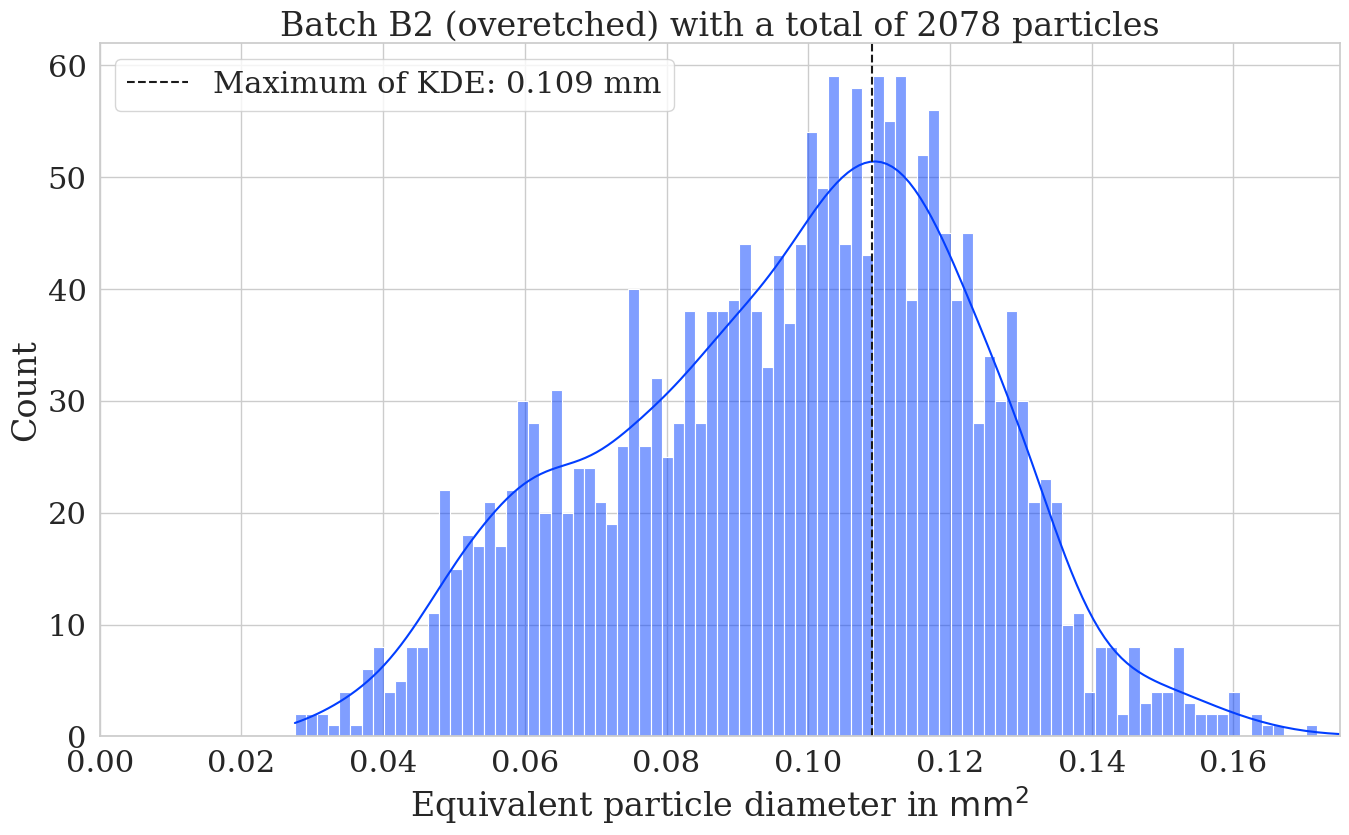

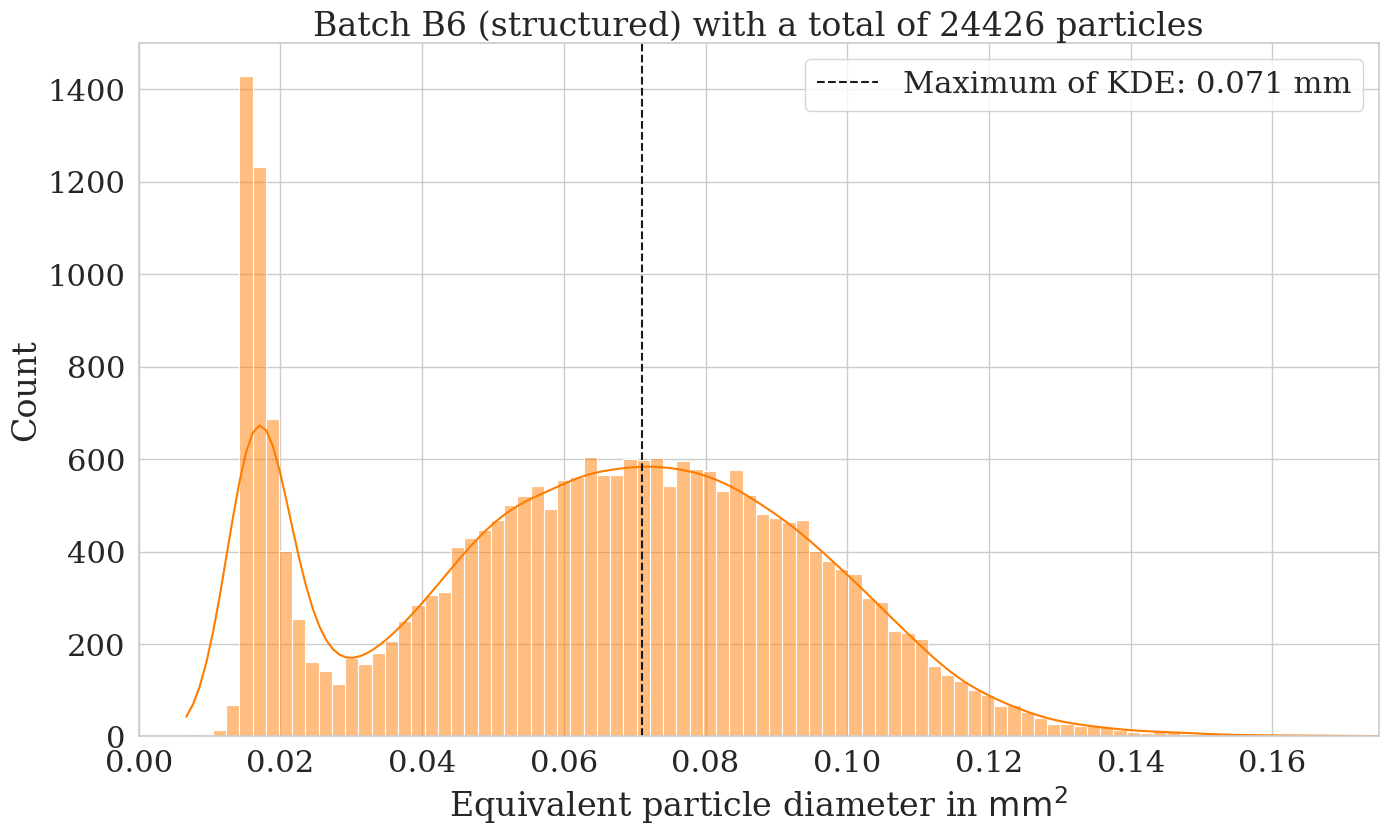

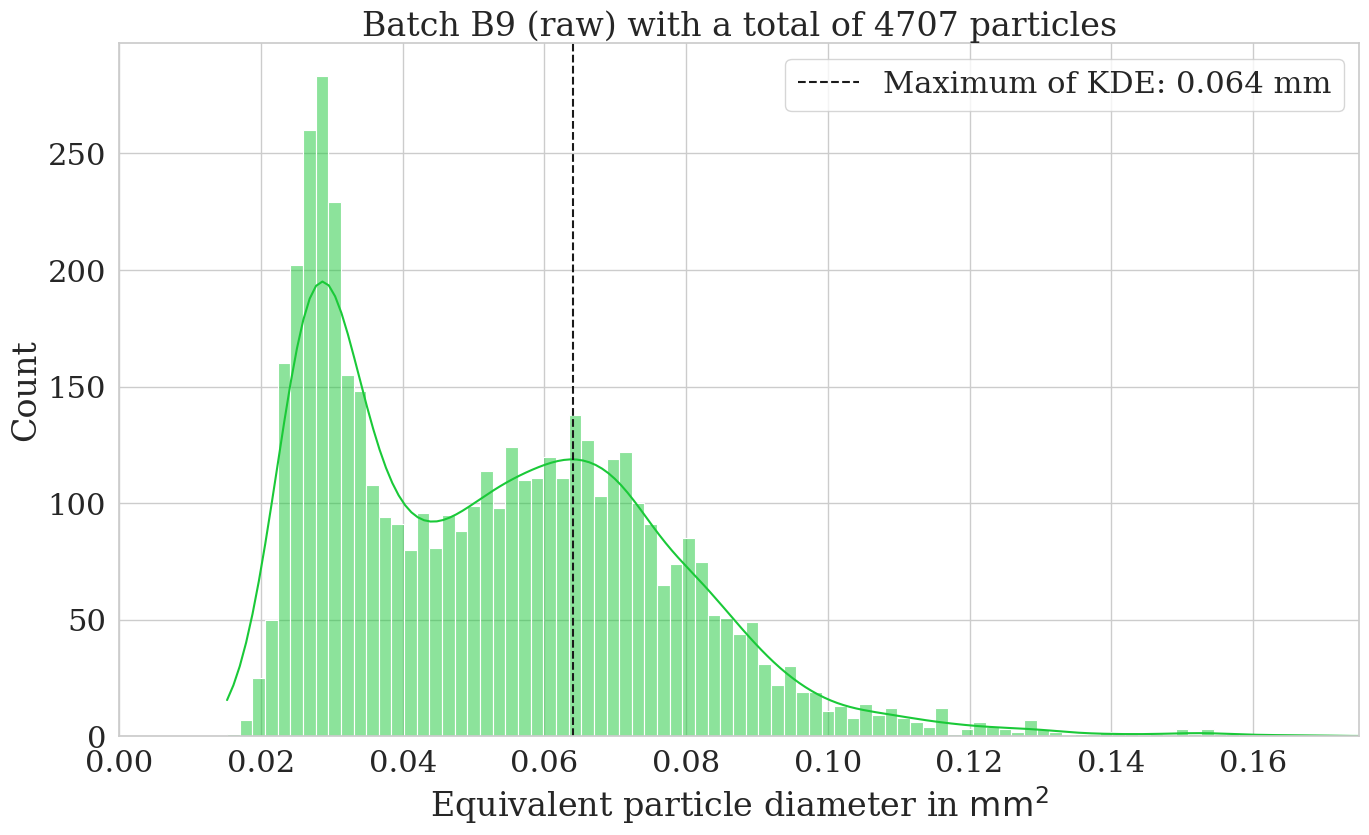

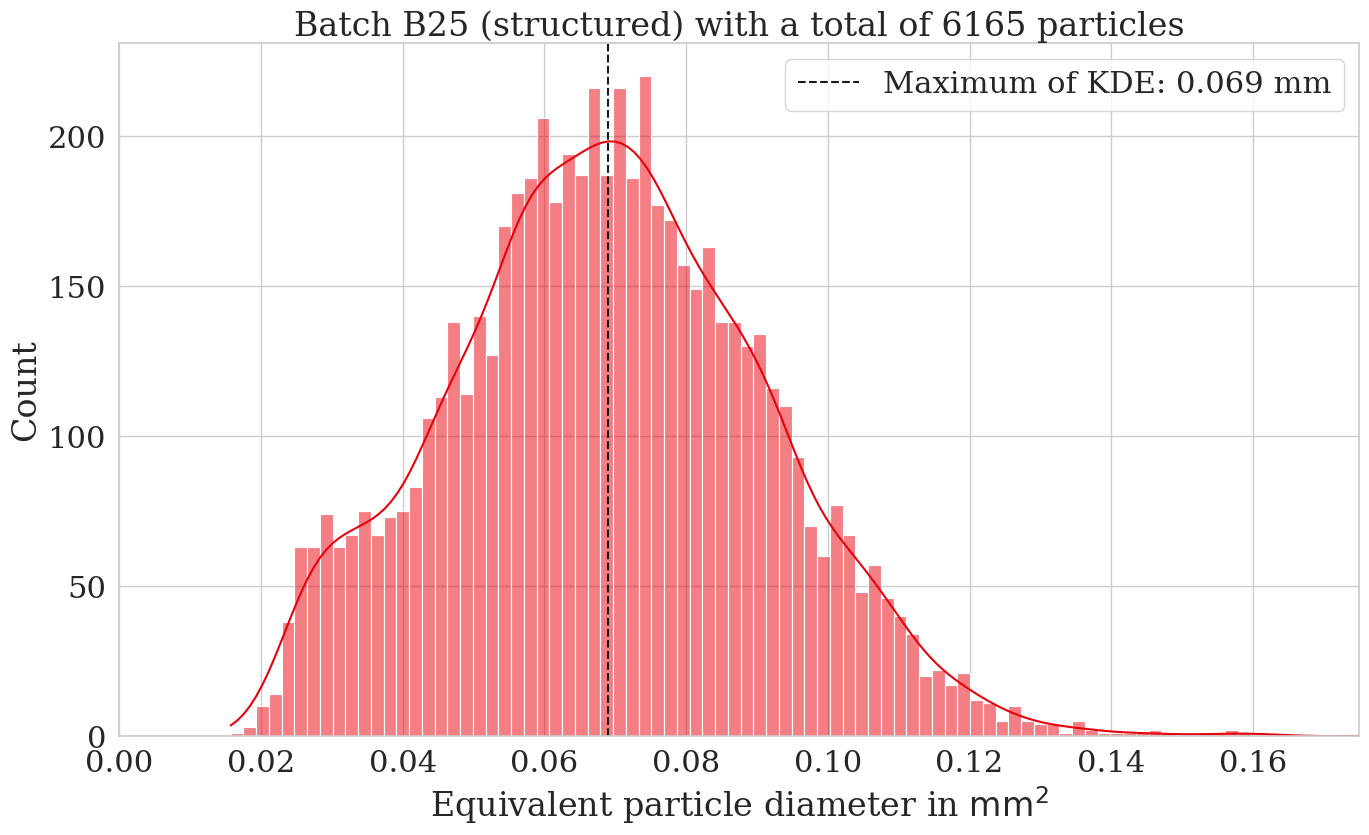

In [10]:
sns.set_context("paper")
sns.set_theme(font="serif", style="whitegrid", font_scale=2)
peaks = [0.109, 0.071, 0.064, 0.069]
cmap = sns.color_palette("bright", 4)
for ii, batch in enumerate(batch_names):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    df = pd.DataFrame(diameter_distribution[batch], columns=["Equivalent particle diameter in $\mathrm{mm^2}$"])
    sns.histplot(df,
                 x="Equivalent particle diameter in $\mathrm{mm^2}$",
                 bins=100,
                 ax=ax,
                 kde=True,
                 color=cmap[ii])
    ax.axvline(peaks[ii], color="k", linestyle="--", label="Maximum of KDE: " + str(peaks[ii]) + " mm")
    ax.legend()
    ax.set_title("Batch " + batch + " with a total of " + str(len(diameter_distribution[batch])) + " particles")
    ax.set_ylabel('Count')
    ax.set_xlim(0, 0.175)
    fig.savefig("../../06_Results/ParticleSizeDistribution/" + batch + ".pdf", bbox_inches="tight", pad_inches=0)
    fig.savefig("../../06_Results/ParticleSizeDistribution/" + batch + ".png", bbox_inches="tight", pad_inches=0)

# Al-PMMA contact
Contact between Al and PMMA depending on settings.

In [7]:
df = specimen_overview[
    (specimen_overview["analysis"] == "y")
    & ((specimen_overview["description"] == "time constant testing")
    | (specimen_overview["description"] == "standard setting batch test"))][["specimen", "settings", "Batch"]]

import re

settings = df["settings"].apply(lambda x: [int(ii) for ii in re.findall(r'\d+', x)]).values
all_settings = []
for setting in settings:
    if setting == []: # Standard setting
        all_settings.append(get_func_gen_settings(on_time=0.01, off_time=0.02, passes=10, focus_distance=45, verbose=False))
    else:
        all_settings.append(get_func_gen_settings(on_time=setting[1] * 1e-3, off_time=setting[2] * 1e-3, passes=setting[0],
                                              focus_distance=45, verbose=False))

df = df.reset_index(drop=True)
df_settings = pd.DataFrame(all_settings)
df = df.join(df_settings[["actual_on_time", "actual_off_time", "passes"]])
df["air_volume"] = [analytics[specimen]["mask_analytics"]["total_air_volume_mm3"] * 2 ** 3 for specimen in
                    df["specimen"]]
df["ratio"] = df["actual_off_time"] / df["actual_on_time"]
df["density"] = [1 / (np.mean(analytics[specimen]["2d_cell_area"] * SCALE_FACTOR_2D)) for specimen in df["specimen"]]
df["contact"] = [100 - analytics[specimen]["mask_analytics"]["contact_air_Al_percent"] for specimen in df["specimen"]]
df = df.drop(["settings", "actual_off_time"], axis=1)
df

,specimen,Batch,actual_on_time,passes,air_volume,ratio,density,contact
0,AD67,B2,0.010042,10,0.078526,2.000000,47.293388,96.186373
1,AD66,B9,0.010042,10,0.004239,2.000000,168.808441,99.694756
2,AD64,B25,0.010042,10,0.033935,2.000000,89.396077,96.318909
3,AD63,B6,0.010042,10,0.131021,2.000000,67.376339,93.057777
4,AD45,B25,0.010042,10,0.171683,2.000000,47.396571,82.358138
5,AD43,B6,0.009979,7,0.057550,2.000000,66.814036,95.272177
6,AD42,B6,0.009979,5,0.487759,2.000000,52.479889,71.981411
7,AD40,B25,0.010042,10,0.335910,2.000000,63.397342,64.358773
8,AD38,B2,0.010042,10,0.221702,2.000000,39.764615,94.972598
9,AD36,B9,0.010042,10,0.157111,2.000000,105.423854,89.936007


In [8]:
df[["specimen", "contact", "air_volume"]]

,specimen,contact,air_volume
0,AD67,96.186373,0.078526
1,AD66,99.694756,0.004239
2,AD64,96.318909,0.033935
3,AD63,93.057777,0.131021
4,AD45,82.358138,0.171683
5,AD43,95.272177,0.057550
6,AD42,71.981411,0.487759
7,AD40,64.358773,0.335910
8,AD38,94.972598,0.221702
9,AD36,89.936007,0.157111


In [11]:
specimen = "AD66"
path = "../../04_uCT/" + specimen + "/"
scan = Scan(path,
            downscale=True)
scan.load(logging=False)

scan.show("z")


Loading pickled Scan object from: ../../06_Results/uCT/AD66/Scan.pkl
Downscaled stack to: (890, 36, 1149)


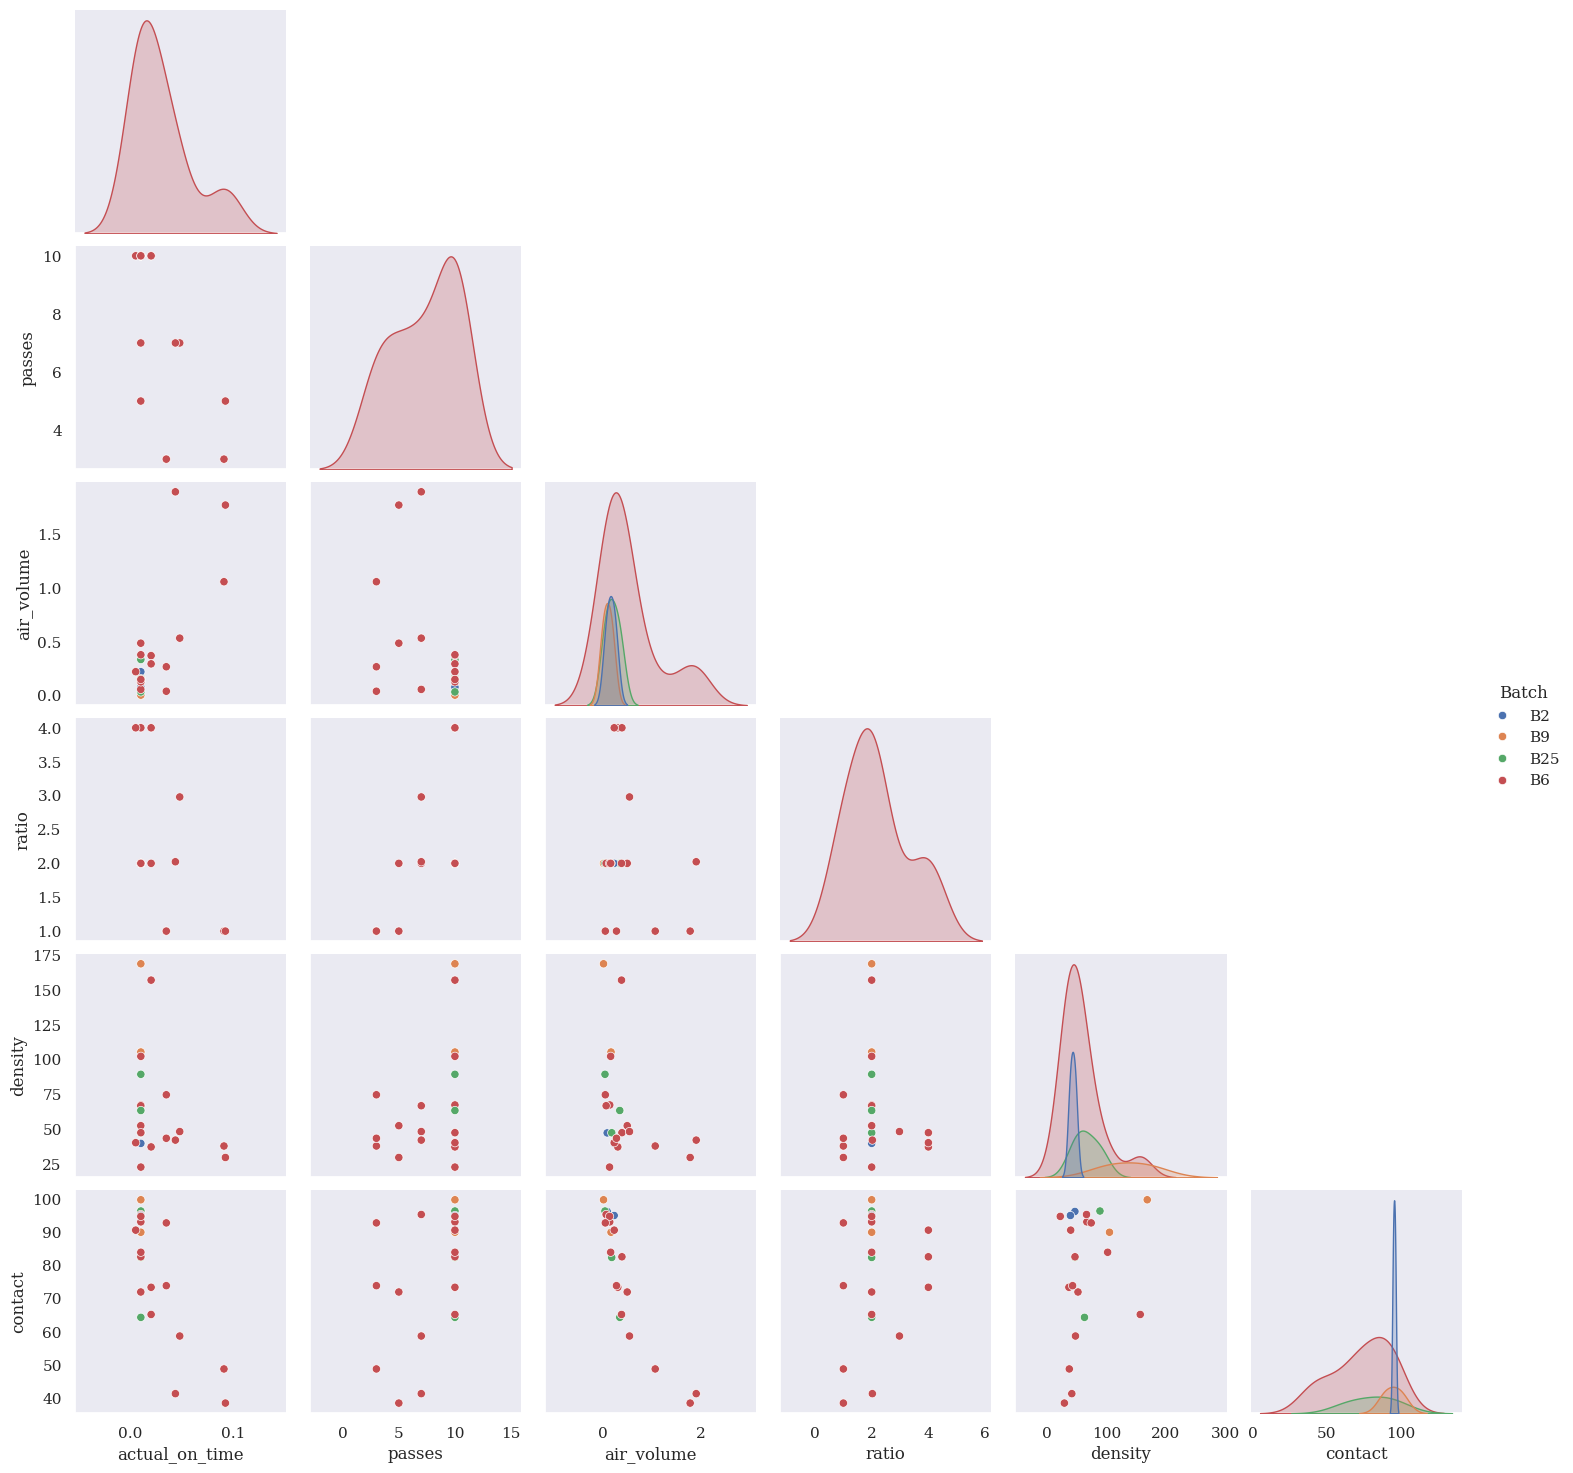

In [14]:
sns.pairplot(df, hue="Batch", corner=True, diag_kind="kde")
plt.savefig("../../06_Results/SettingsTest/Pairplot.pdf", bbox_inches="tight", pad_inches=0)